# CNN trained on local data

## Adapted from DSCI 572 Lab 4

In [4]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
import sklearn

from skimage.io import imread
import re
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain
from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet, nasnet


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
plt.rcParams['font.size'] = 16

## Getting image paths and labels

In [6]:
root_captioning = "../s3/jamesh/"

In [7]:
def get_img_info():
    """
    Returns img paths and captions
    
    Return:
    --------
    list, list
        img paths, corresponding captions
    """
    img_paths = []
    captions = [] 
    for folder in os.listdir(root_captioning):
        if folder == ".DS_Store":
            break
        for file in os.listdir(root_captioning + folder):
            img_paths.append(root_captioning+folder+"/"+file)
            captions.append(folder)
    
    return img_paths, captions           


In [8]:
paths, classes = get_img_info()

In [9]:
paths[0]

'../s3/jamesh/snowberg/snowberg_105.jpg'

In [10]:
print(len(classes))
print(len(set(classes)))

20300
29


In [11]:
labels = set(classes)
labels

{'airport',
 'baseball_diamond',
 'bridge',
 'circular_farmland',
 'cloud',
 'dense_residential',
 'desert',
 'forest',
 'golf_course',
 'ground_track_field',
 'harbor',
 'industrial_area',
 'intersection',
 'island',
 'lake',
 'meadow',
 'medium_residential',
 'mobile_home_park',
 'mountain',
 'overpass',
 'rectangular_farmland',
 'river',
 'roundabout',
 'runway',
 'sea_ice',
 'snowberg',
 'sparse_residential',
 'stadium',
 'tennis_court'}

In [12]:
d = dict()
i = 0
for label in labels:
    if label not in d:
        d[label] = i
        i += 1
print(d)

{'harbor': 0, 'roundabout': 1, 'tennis_court': 2, 'desert': 3, 'industrial_area': 4, 'runway': 5, 'river': 6, 'mobile_home_park': 7, 'dense_residential': 8, 'ground_track_field': 9, 'cloud': 10, 'overpass': 11, 'snowberg': 12, 'medium_residential': 13, 'meadow': 14, 'lake': 15, 'mountain': 16, 'bridge': 17, 'sea_ice': 18, 'intersection': 19, 'sparse_residential': 20, 'golf_course': 21, 'stadium': 22, 'forest': 23, 'island': 24, 'rectangular_farmland': 25, 'circular_farmland': 26, 'airport': 27, 'baseball_diamond': 28}


> The dataset is specified to have 29 classes, and each class has exactly 700 images.

In [13]:
class_train_paths, class_test_paths, class_train_classes, class_test_classes = sklearn.model_selection.train_test_split(paths, classes, test_size = 0.2)

## Training baseline model with 1 color channel

In [39]:
train_img = []
y_train = []
train_length = len(class_train_paths)
for i in range(0, train_length):
    # defining the image path
    image_path = class_train_paths[i]
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
    y_train.append(class_train_classes[i])
    
# converting the list to numpy array
X_train = np.array(train_img)
# defining the target
X_train.shape
y_train = np.array(y_train)
for i in range(0, len(y_train)):
    y_train[i] = d[y_train[i]]
y_train = y_train.astype(int);
print(X_train.shape)

(16240, 256, 256)


In [40]:
test_img = []
y_test = []
test_length = len(class_test_paths)
for i in range(0, test_length):
    # defining the image path
    image_path = class_test_paths[i]
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)
    y_test.append(class_test_classes[i])
    
# converting the list to numpy array
X_test = np.array(test_img)
# defining the target
X_test.shape
y_test = np.array(y_test)
for i in range(0, len(y_test)):
    y_test[i] = d[y_test[i]]
y_test = y_test.astype(int)
print(X_test.shape)

(4060, 256, 256)


In [42]:
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1).astype('float32')

# one hot encode outputs
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(num_classes)

(16240, 256, 256, 1)
(16240, 29)
(4060, 256, 256, 1)
(4060, 29)
29


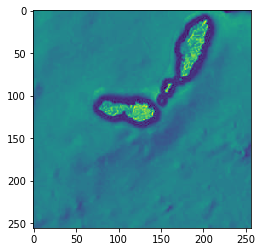

In [43]:
plt.imshow(X_train[0].reshape([256,256]))

In [44]:
# define a simple CNN model
def build_mnist_CNN():
    mnist_model = Sequential()
    mnist_model.add(Conv2D(32, (5, 5), input_shape=(256, 256, 1), activation='relu'))
    mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
    mnist_model.add(Dropout(0.2))
    mnist_model.add(Flatten())
    mnist_model.add(Dense(128, activation='relu'))
    mnist_model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    mnist_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mnist_model

In [45]:
mnist_model = build_mnist_CNN()

In [46]:
# Fit the model
mnist_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256)
# Final evaluation of the model
scores = mnist_model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
64/64 [==============================] - 8s 118ms/step - loss: 3.1806 - accuracy: 0.0864 - val_loss: 3.0478 - val_accuracy: 0.1103
Epoch 2/10
64/64 [==============================] - 7s 109ms/step - loss: 3.0107 - accuracy: 0.1299 - val_loss: 2.9820 - val_accuracy: 0.1310
Epoch 3/10
64/64 [==============================] - 7s 109ms/step - loss: 2.9334 - accuracy: 0.1584 - val_loss: 2.8917 - val_accuracy: 0.1702
Epoch 4/10
64/64 [==============================] - 7s 110ms/step - loss: 2.8518 - accuracy: 0.1823 - val_loss: 2.8534 - val_accuracy: 0.1904
Epoch 5/10
64/64 [==============================] - 7s 109ms/step - loss: 2.7891 - accuracy: 0.1973 - val_loss: 2.8016 - val_accuracy: 0.1948
Epoch 6/10
64/64 [==============================] - 7s 109ms/step - loss: 2.7151 - accuracy: 0.2201 - val_loss: 2.7467 - val_accuracy: 0.2069
Epoch 7/10
64/64 [==============================] - 7s 109ms/step - loss: 2.6887 - accuracy: 0.2287 - val_loss: 2.6789 - val_accuracy: 0.2389
Epoch 

> With 29 different classes, the baseline model's validation accuracy of 0.25 is not too bad.

## Training baseline model with all 3 colour channels

In [14]:
train_img = []
y_train = []
train_length = len(class_train_paths)
for i in range(0, train_length):
    # defining the image path
    image_path = class_train_paths[i]
    # reading the image
    img = imread(image_path)
    # converting the type of pixel to float 32 and normalizing
    img = img.astype('float32')/255.0
    # appending the image into the list
    train_img.append(img)
    y_train.append(class_train_classes[i])
    
# converting the list to numpy array
X_train = np.array(train_img)
# defining the target
X_train.shape
y_train = np.array(y_train)
for i in range(0, len(y_train)):
    y_train[i] = d[y_train[i]]
y_train = y_train.astype(int);
print(X_train.shape)
y_train

(16240, 256, 256, 3)


array([18, 17, 23, ..., 17,  2, 25])

In [15]:
test_img = []
y_test = []
test_length = len(class_test_paths)
for i in range(0, test_length):
    # defining the image path
    image_path = class_test_paths[i]
    # reading the image
    img = imread(image_path)
    # converting the type of pixel to float 32 and normalizing
    img = img.astype('float32')/255.0
    # appending the image into the list
    test_img.append(img)
    y_test.append(class_test_classes[i])
    
# converting the list to numpy array
X_test = np.array(test_img)
# defining the target
X_test.shape
y_test = np.array(y_test)
for i in range(0, len(y_test)):
    y_test[i] = d[y_test[i]]
y_test = y_test.astype(int)
print(X_test.shape)
y_test

(4060, 256, 256, 3)


array([ 0,  0,  4, ..., 15, 27, 25])

In [16]:
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 256, 256, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 256, 256, 3).astype('float32')

# one hot encode outputs
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(num_classes)

(16240, 256, 256, 3)
(16240, 29)
(4060, 256, 256, 3)
(4060, 29)
29


In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu')) # this is just different syntax for specifying the activation function
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
activation_94 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_95 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 60, 60, 64)        1

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
508/508 [==============================] - 14s 27ms/step - loss: 3.0757 - accuracy: 0.1137 - val_loss: 2.5163 - val_accuracy: 0.2490
Epoch 2/10
508/508 [==============================] - 13s 26ms/step - loss: 2.5488 - accuracy: 0.2244 - val_loss: 2.0672 - val_accuracy: 0.3946
Epoch 3/10
508/508 [==============================] - 13s 26ms/step - loss: 2.3063 - accuracy: 0.2784 - val_loss: 1.8915 - val_accuracy: 0.4246
Epoch 4/10
508/508 [==============================] - 13s 26ms/step - loss: 2.1661 - accuracy: 0.3176 - val_loss: 1.7902 - val_accuracy: 0.4443
Epoch 5/10
505/508 [============================>.] - ETA: 0s - loss: 2.0513 - accuracy: 0.3400

> Kernel keeps dying.

## Transfer learning with InceptionV3

In [22]:
# Get the InceptionV3 model trained on the ImageNet data set
base_inception = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [23]:
top_block = base_inception.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_inception.input, outputs=predictions)

In [24]:
for layer in base_inception.layers:
    layer.trainable = False

In [25]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model_transfer.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 127, 127, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 127, 127, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
507/508 [============================>.] - ETA: 0s - loss: 0.8487 - accuracy: 0.7446

> This basic model utilizing a pretrained model gets an accuracy of 87% which is much better than our model from scratch.

In [ ]:
for i, layer in enumerate(reversed(model_transfer.layers)):
    layer.trainable = True
#     print(layer)
    if i > 15:
        break

# compile the model with a SGD/momentum optimizer and a very slow learning rate.
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

> By unfreezing the last 15 layers of the model it becomes more flexible and we achieved a slightly better result using this model.

> Overall using transfer learning is much more effective than training a model from scratch.

## Transfer Learning with VGG16

In [ ]:
base_VGG16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
top_block = base_VGG16.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_VGG16.input, outputs=predictions)

In [1]:
for layer in base_VGG16.layers:
    layer.trainable = False

NameError: name 'base_VGG16' is not defined

In [ ]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

> This performs somewhat worse than the baseline InceptionV3 model, with a 79% accuracy on the validation set compared to 87%.

## Transfer Learning with ResNet

In [ ]:
base_resnet = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
top_block = base_resnet.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_resnet.input, outputs=predictions)

In [ ]:
for layer in base_resnet.layers:
    layer.trainable = False

In [ ]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

> This is terrible. Maybe something went wrong with model creation.

## Transfer Learning with NASNetLarge

In [ ]:
base_nasnet = nasnet.NASNetLarge(weights='imagenet', include_top=False)

In [ ]:
top_block = base_nasnet.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_nasnet.input, outputs=predictions)

In [ ]:
for layer in base_nasnet.layers:
    layer.trainable = False

In [ ]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

> This performs similarly to the InceptionV3 model.